In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Data gathering

In [2]:
# get data
# read static data
artists_table = pd.read_csv('data/artists_table.csv')
albums_table = pd.read_csv('data/albums_table.csv')
tracks_table = pd.read_csv('data/tracks_table.csv')
tracks_faeaures_table = pd.read_csv('data/tracks_features_table.csv')
tracks_popularity_table = pd.read_csv('data/tracks_popularity_table.csv', parse_dates=['date'])

In [3]:
# merge to get tracks data
data = pd.merge(tracks_table, albums_table, on='album_id')
data = pd.merge(data, artists_table, on='artist_id')
# get the last date of popularity
data = pd.merge(data, tracks_popularity_table.query('date == @tracks_popularity_table.date.max()'), on='track_id')
data = pd.merge(data, tracks_faeaures_table, on='track_id')

# drop unnecessary columns
data = data.drop(['track_spotify_url', 'track_preview_url', 'album_image_large', 
                  'album_image_medium', 'album_image_small',
                  'uri', 'analysis_url', 'track_href', 'duration_ms'], axis=1)

We will keep only the most popular version of each duplicated track. We must do this separately for each artist in order to avoid removing tracks that are different but share the same name. Therefore we group by `artist_name` and `original_track_name`. We keep the duplicated tracks with the highest popularity.

In [4]:
data = (data
        .groupby(['artist_name', 'original_track_name'])
        .apply(lambda x: x.sort_values('track_popularity', ascending=False)
               .head(1)
               )
        .reset_index(drop=True)
        )

C:\Users\vange\AppData\Local\Temp\ipykernel_6068\737540452.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = (data


In [5]:
# convert duration to seconds
data['track_duration_sec'] = data['track_duration_ms']/1000
data = data.drop('track_duration_ms', axis=1)

### Clustering
We will cluster the tracks based on the following acoustic features; 
`danceability`, `energy`, `loudness`, `speechiness`, `acousticness`, `instrumentalness`, `valence`, `tempo`.

In [6]:
# selecting the features for the model
X = data[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']]
X.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
0,0.403,0.806,-4.727,0.0562,0.009190,0.035300,0.551,123.819
1,0.569,0.591,-3.962,0.0370,0.022200,0.001230,0.577,102.685
2,0.605,0.900,-2.717,0.0291,0.000522,0.027100,0.467,120.895
3,0.452,0.821,-4.816,0.0324,0.016500,0.000004,0.414,108.529
4,0.310,0.700,-5.678,0.0470,0.011000,0.009650,0.763,188.386


Every feature except `loudness` and `tempo` is in the range [0, 1]. Therefore, we will rescale those features as well.

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = X.copy()
# Scale only 'loudness' and 'tempo'
X.loc[:, ['loudness', 'tempo']] = scaler.fit_transform(X[['loudness', 'tempo']])
X.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
0,0.403,0.806,0.883206,0.0562,0.009190,0.035300,0.551,0.572430
1,0.569,0.591,0.903168,0.0370,0.022200,0.001230,0.577,0.474725
2,0.605,0.900,0.935654,0.0291,0.000522,0.027100,0.467,0.558912
3,0.452,0.821,0.880884,0.0324,0.016500,0.000004,0.414,0.501743
4,0.310,0.700,0.858392,0.0470,0.011000,0.009650,0.763,0.870932


We will use K-means to investigate the optimal number of clusters by computing the *inertia* for different values of $K$.

c:\Users\vange\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\vange\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


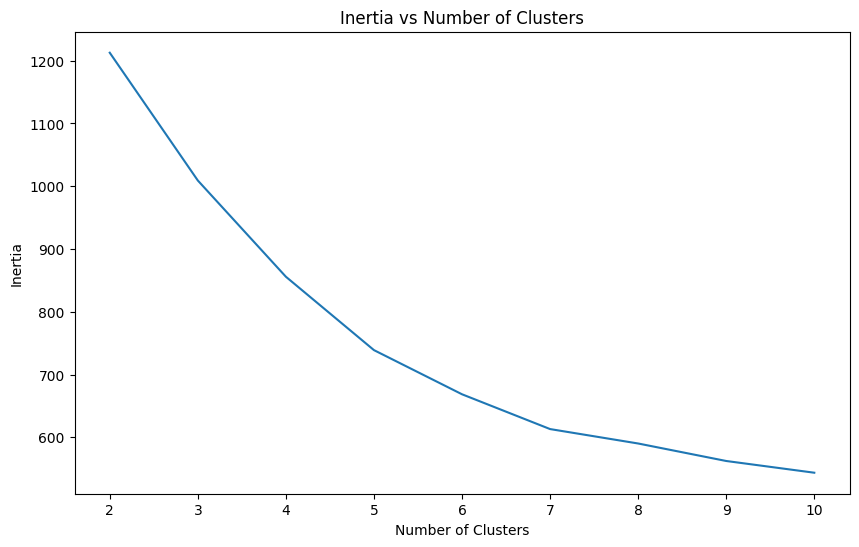

In [8]:
# plot inertia for different number of clusters
from sklearn.cluster import KMeans
inertia = []
for k in range(2, 11):
    model = KMeans(n_clusters=k,init='k-means++', n_init='auto',random_state=42)
    model.fit(X)
    inertia.append(model.inertia_)

# create the plot
plt.figure(figsize=(10,6))
plt.plot(range(2, 11), inertia)
plt.title('Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


We choose $K = 5$

In [9]:
model = KMeans(n_clusters=5,  init='k-means++', n_init='auto',random_state=42)
model.fit(X)
# add the cluster column to the data
data['cluster'] = model.predict(X)
data['cluster'].value_counts()

cluster
2    1682
0    1673
3     969
4     475
1     315
Name: count, dtype: int64

We create a heatmap displaying the average acoustic features for each cluster.

In [10]:
# add scaled features to the data to create the heat map
data[['loudness_scaled', 'tempo_scaled']] = X[['loudness', 'tempo']]
# group by cluster and calculate the mean
group = (data
         .groupby('cluster')[['danceability', 'energy', 'loudness_scaled', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo_scaled']]
         .mean()
)

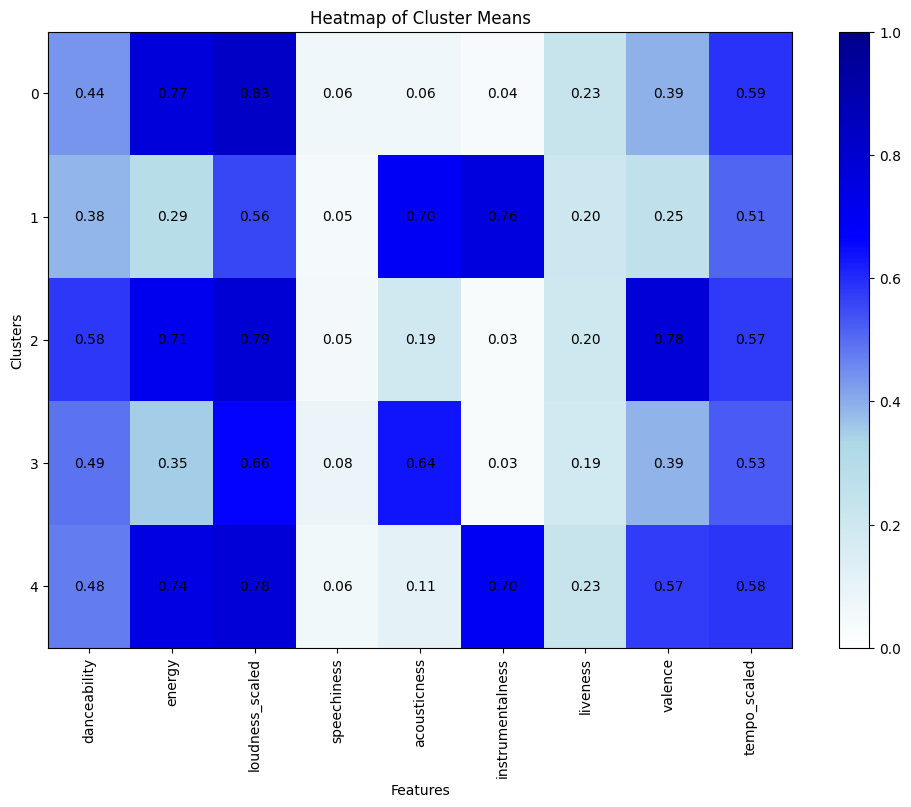

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Assuming 'group' is a DataFrame with the cluster means as in your previous code

# Define the custom color map
colors = ['white', 'lightblue', 'blue', 'darkblue']
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

# Convert the DataFrame to a 2D numpy array
data_array = group.to_numpy()

# Create the figure and axis
plt.figure(figsize=(12, 8))
# Display the data as an image
cax = plt.imshow(data_array, interpolation='nearest', cmap=cmap, aspect='auto', vmin=0, vmax=1)

# Add color bar
plt.colorbar(cax)

# Set the ticks: assume the index for rows and columns are integers starting from 0
plt.xticks(range(len(group.columns)), group.columns, rotation=90)
plt.yticks(range(len(group.index)), group.index)

# Annotate each cell with the numeric value, all in black
for i in range(data_array.shape[0]):
    for j in range(data_array.shape[1]):
        plt.text(j, i, f'{data_array[i, j]:.2f}',
                 ha='center', va='center', color='black')

# Optional: Add title and axis labels as needed
plt.title('Heatmap of Cluster Means')
plt.xlabel('Features')
plt.ylabel('Clusters')

plt.show()

#### Cluster interpretation
- Cluster 0: Low `valence`, High `energy`, High `loudness`, High `tempo`.
This cluster includes energetic and loud tracks that are generally negative in mood (e.g., sad, depressed, angry).

- Cluster 1: Low `valence`, Low `energy`, High `acousticness`, High `instrumentalness`, Lower `tempo`.
This cluster includes instrumental acoustic tracks with a negative mood, characterized by low energy and a slower tempo.

- Cluster 2: High `valence`, High `energy`, High `danceability`, High `loudness`, Higher `tempo`.
This cluster consists of tracks that are positive in mood (e.g., happy, cheerful, euphoric), energetic, loud, and danceable.

- Cluster 3: Medium to Low `valence`, Low `energy`, High `acousticness`, High `loudness`.
This cluster includes non-instrumental acoustic tracks that have low energy and are generally not highly positive in mood.

- Cluster 4: Relatively High `valence`, High `energy`, High `instrumentalness`, High `loudness`, Higher `tempo`.
This cluster consists of instrumental tracks that are positive in mood and highly energetic.








In [13]:
# drop unnecessary columns
data = data.drop(['album_total_tracks', 'artist_image_medium', 'artist_image_small', 'track_popularity'], axis=1)
# save the data to a csv file for later use
data.to_csv('data/tracks_clustered.csv', index=False)
data.head()

,track_id,album_id,track_name,track_duration_display,original_track_name,artist_id,album_name,album_release_date,original_album_name,artist_name,...,acousticness,instrumentalness,liveness,valence,tempo,type,track_duration_sec,cluster,loudness_scaled,tempo_scaled
0,73HVgj1xXW9vuiRsFAKwyr,76mvVgXOde87B9aOzLXCOI,Ain't No Fun (Waiting Round to Be a Millionaire),6:54,Ain't No Fun (Waiting Round to Be a Millionaire),711MCceyCBcFnzjGY4Q7Un,Dirty Deeds Done Dirt Cheap,1976,Dirty Deeds Done Dirt Cheap,AC/DC,...,0.009190,0.035300,0.1130,0.551,123.819,audio_features,414.026,0,0.883206,0.572430
1,2filqLyVGxteotSCD8b4Jt,5JPVHEB67TREre4Q8JOfCQ,All Screwed Up,4:36,All Screwed Up,711MCceyCBcFnzjGY4Q7Un,Stiff Upper Lip,2000,Stiff Upper Lip,AC/DC,...,0.022200,0.001230,0.0771,0.577,102.685,audio_features,276.400,0,0.903168,0.474725
2,4OrKIUhgiIiOefxwmrVedV,7qVfz4UGONwEd5nQjj0ESN,Anything Goes,3:22,Anything Goes,711MCceyCBcFnzjGY4Q7Un,Black Ice,2008,Black Ice,AC/DC,...,0.000522,0.027100,0.0466,0.467,120.895,audio_features,202.160,0,0.935654,0.558912
3,7A1odihHBrI8n9k0Fefh2j,4vu7F6h90Br1ZtYYaqfITy,Are You Ready,4:10,Are You Ready,711MCceyCBcFnzjGY4Q7Un,The Razors Edge,1990,The Razors Edge,AC/DC,...,0.016500,0.000004,0.1300,0.414,108.529,audio_features,250.333,0,0.880884,0.501743
4,08mG3Y1vljYA6bvDt4Wqkj,6mUdeDZCsExyJLMdAfDuwh,Back In Black,4:15,Back In Black,711MCceyCBcFnzjGY4Q7Un,Back In Black,1980,Back In Black,AC/DC,...,0.011000,0.009650,0.0828,0.763,188.386,audio_features,255.493,2,0.858392,0.870932


#### Cluster Investigation

- We saw that `energy` and `valence` were crucial for determining the clusters. 

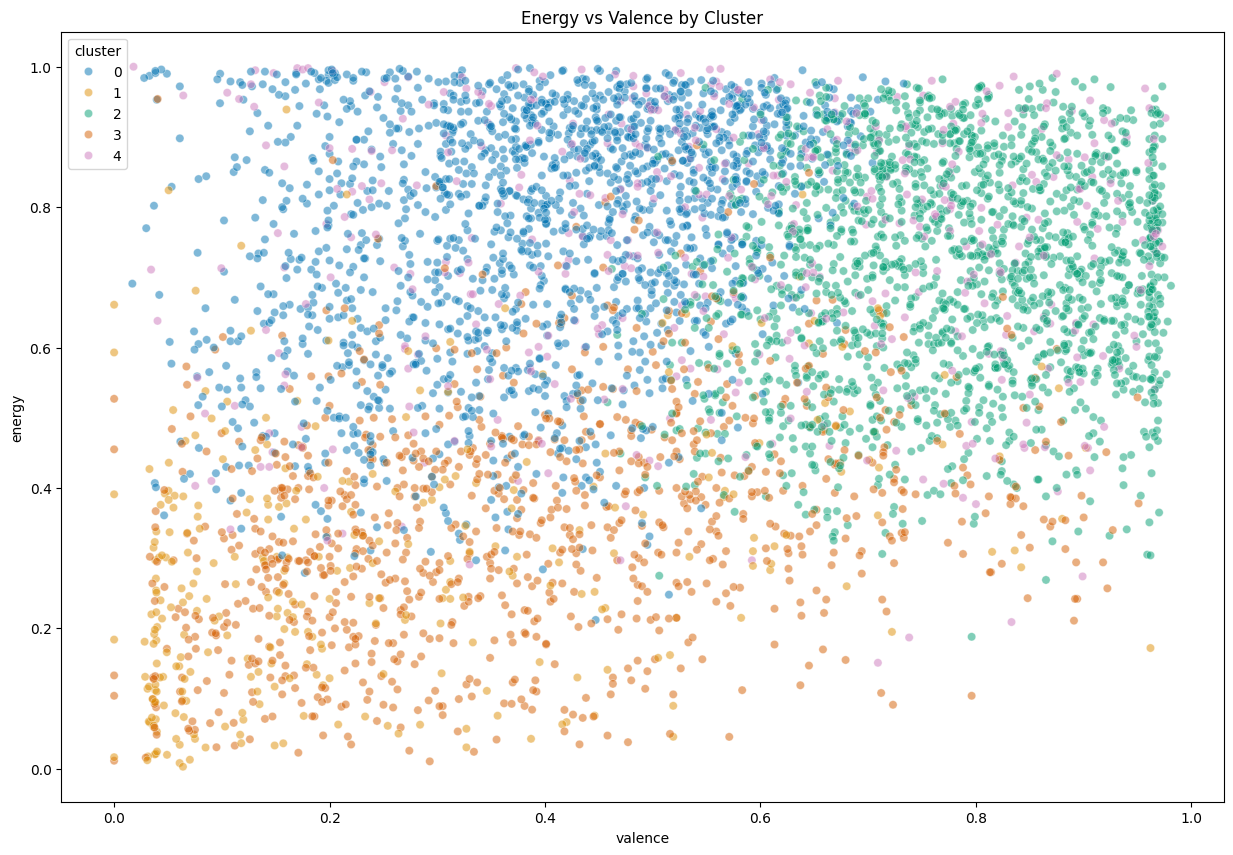

In [14]:
plt.figure(figsize=(15, 10))
# Creating the bubble chart
sns.scatterplot(x=data['valence'], y=data['energy'], hue=data['cluster'], palette='colorblind',
                 alpha=0.5, sizes=(400, 20))

plt.title('Energy vs Valence by Cluster')
plt.show()

- Let's explore popularity by cluster.

In [15]:
# gettin the data needed
track_popularity = pd.read_pickle('data.pkl')[['track_id', 'current_track_popularity']]
track_popularity.head()

,track_id,current_track_popularity
0,73HVgj1xXW9vuiRsFAKwyr,41
1,2filqLyVGxteotSCD8b4Jt,34
2,4OrKIUhgiIiOefxwmrVedV,44
3,7A1odihHBrI8n9k0Fefh2j,59
4,08mG3Y1vljYA6bvDt4Wqkj,84


In [16]:
data = pd.merge(data, track_popularity, on='track_id') 
data = data.rename(columns={'current_track_popularity': 'track_popularity'})
data.head()

,track_id,album_id,track_name,track_duration_display,original_track_name,artist_id,album_name,album_release_date,original_album_name,artist_name,...,instrumentalness,liveness,valence,tempo,type,track_duration_sec,cluster,loudness_scaled,tempo_scaled,track_popularity
0,73HVgj1xXW9vuiRsFAKwyr,76mvVgXOde87B9aOzLXCOI,Ain't No Fun (Waiting Round to Be a Millionaire),6:54,Ain't No Fun (Waiting Round to Be a Millionaire),711MCceyCBcFnzjGY4Q7Un,Dirty Deeds Done Dirt Cheap,1976,Dirty Deeds Done Dirt Cheap,AC/DC,...,0.035300,0.1130,0.551,123.819,audio_features,414.026,0,0.883206,0.572430,41
1,2filqLyVGxteotSCD8b4Jt,5JPVHEB67TREre4Q8JOfCQ,All Screwed Up,4:36,All Screwed Up,711MCceyCBcFnzjGY4Q7Un,Stiff Upper Lip,2000,Stiff Upper Lip,AC/DC,...,0.001230,0.0771,0.577,102.685,audio_features,276.400,0,0.903168,0.474725,34
2,4OrKIUhgiIiOefxwmrVedV,7qVfz4UGONwEd5nQjj0ESN,Anything Goes,3:22,Anything Goes,711MCceyCBcFnzjGY4Q7Un,Black Ice,2008,Black Ice,AC/DC,...,0.027100,0.0466,0.467,120.895,audio_features,202.160,0,0.935654,0.558912,44
3,7A1odihHBrI8n9k0Fefh2j,4vu7F6h90Br1ZtYYaqfITy,Are You Ready,4:10,Are You Ready,711MCceyCBcFnzjGY4Q7Un,The Razors Edge,1990,The Razors Edge,AC/DC,...,0.000004,0.1300,0.414,108.529,audio_features,250.333,0,0.880884,0.501743,59
4,08mG3Y1vljYA6bvDt4Wqkj,6mUdeDZCsExyJLMdAfDuwh,Back In Black,4:15,Back In Black,711MCceyCBcFnzjGY4Q7Un,Back In Black,1980,Back In Black,AC/DC,...,0.009650,0.0828,0.763,188.386,audio_features,255.493,2,0.858392,0.870932,84


In [17]:
group = (data
            .groupby('cluster')
            .agg({'track_popularity': [('median', 'median'), ('mean', 'mean')]})
            .reset_index()
            .sort_values(('track_popularity', 'mean'), ascending=False)
            )
group

cluster track_popularity           
                    median       mean
0       0             33.0  34.320574
2       2             30.0  32.594401
3       3             28.0  29.760331
4       4             28.0  29.553684
1       1             26.0  27.168254

In [18]:
data['cluster'].value_counts(normalize=True).apply(lambda x: str(round(x*100)) + '%')

cluster
2    33%
0    33%
3    19%
4     9%
1     6%
Name: proportion, dtype: object

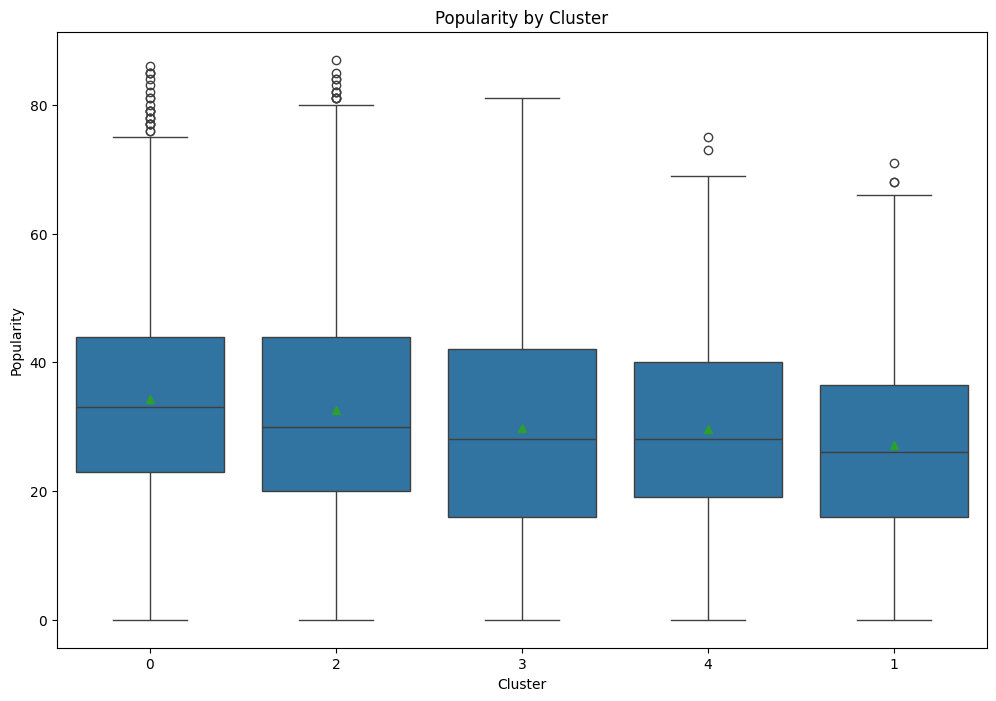

In [19]:
# box plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=data, x='cluster', y='track_popularity', order=group['cluster'], showmeans=True)
plt.title('Popularity by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Popularity')
plt.show()

It seems that the tracks in cluster 1 are less popular on average. Clusters 4 and 2 may contain more popular tracks on average. We can conduct an ANOVA test to check this. The high popularity tracks are not a problem because the order of magnitude is the same since `track_popularity` is a number in the range [0, 100], and therefore they do not affect the means in a problematic way.

In [20]:
# mean popularity for each cluster
data.groupby('cluster')['track_popularity'].mean()

cluster
0    34.320574
1    27.168254
2    32.594401
3    29.760331
4    29.553684
Name: track_popularity, dtype: float64

In [21]:
# mean popularity without outliers
Q1 = data['track_popularity'].quantile(0.25)
Q3 = data['track_popularity'].quantile(0.75)
IQR = Q3 - Q1
(data
 .query('(@Q1 - 1.5 * @IQR) <= track_popularity <= (@Q3 + 1.5 * @IQR)')
 .groupby('cluster')['track_popularity']
 .mean()
 )

cluster
0    33.838066
1    27.168254
2    32.035542
3    29.605181
4    29.553684
Name: track_popularity, dtype: float64

We conduct an ANOVA test to investigate the popularity of tracks among different clusters.

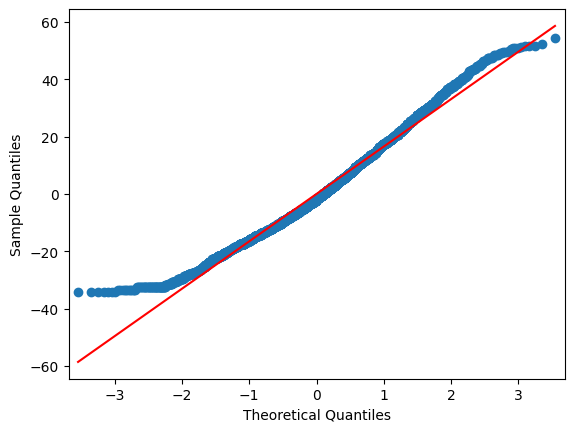

In [22]:
# ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
# create the model
model = ols('track_popularity ~ C(cluster)', data=data).fit()

# Residuals plot
residuals = model.resid
fig, ax = plt.subplots()
sm.qqplot(residuals, line='s', ax=ax)
plt.show()

The residuals are approximately normally distributed. Thus, we can proceed with our ANOVA test.

In [23]:
# ANOVA table
anova_table = sm.stats.anova_lm(model)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(cluster),4.0,2.464905e+04,6162.261944,22.58398,1.630290e-18
Residual,5104.0,1.392677e+06,272.859879,NaN,NaN


The p-value is practically zero, indicating a significant difference in track popularity among clusters. To identify which means are statistically significant, we will conduct a post-hoc test, specifically Tukey's HSD test, to compare every group with each other.

In [24]:
# conducting Tukey's HSD test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=data['track_popularity'], groups=data['cluster'], alpha=0.05)
# display the summary table
print(tukey.summary())


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -7.1523    0.0 -9.9209 -4.3837   True
     0      2  -1.7262 0.0211 -3.2835 -0.1689   True
     0      3  -4.5602    0.0 -6.3807 -2.7398   True
     0      4  -4.7669    0.0 -7.1105 -2.4233   True
     1      2   5.4261    0.0  2.6585  8.1938   True
     1      3   2.5921 0.1103 -0.3318  5.5159  False
     1      4   2.3854 0.2722 -0.8898  5.6607  False
     2      3  -2.8341 0.0002 -4.6531  -1.015   True
     2      4  -3.0407 0.0037 -5.3832 -0.6982   True
     3      4  -0.2066 0.9994 -2.7318  2.3185  False
----------------------------------------------------


Post Hoc Analysis Results:
- Cluster 0 has an average popularity that is 7.2, 1.7, 4.6 and 4.8 points higher than cluster 1, 2, 3 and 4 respectively.

- Clsuter 2 has an average popularity that is 5.4, 2.8 and 3.0 points higher than cluster 1, 3 and 4 respectively.

- Clusters 1 and 3 do not differ significantly in terms of track popularity.

- Clusters 1 and 4 do not differ significantly in terms of track popularity.

- Clusters 3 and 4 do not differ significantly in terms of track popularity.

---